Hunter S. DiCicco

with Dr. Dongwon Lee, Ph.D.

# Multinomial SVC for Categories of News

## Diagnostics to Assess Model Performance

## TODO:
* Rectify Promotional Content/Native Ads Class Balance
* Prepare Pipeline description for misreporting

### Setup and Imports

In [1]:
import pickle
import glob
import copy
import pdb
import sys
import os

from itertools import combinations
from functools import partial

from sklearn.model_selection import KFold, validation_curve
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

os.chdir("../")

from validator import validate

def main():
    """
    Instead of an import, we wrap the execution of both of these vital modules within `exec`.
    This ensures that changes are enacted on every chunk evaluation.
    """
    exec(open("classifier.py").read(), globals())
    exec(open("validator.py").read(), globals())

main()
random_state = 4261998

Retrieving data...
Retrieving data...
Retrieving data...
Retrieving data...
------------
recall:[0.7  0.88 0.03 0.29 0.89]
precision:[0.82 0.84 0.54 0.23 0.51]
f1:[0.75 0.86 0.06 0.26 0.65]
------------

{1: 68, 2: 28, 3: 217, 5: 158, 7: 24}
This model got 55.8% correct || 625 out of 1120.
False negatives for real data (1)
{5: 55, 2: 13}
False negatives for fake data (2)
{5: 28}
False negatives for opinion data (3)
{5: 144, 2: 8, 1: 12, 7: 53}
False negatives for polarized data (5)
{7: 139, 3: 4, 2: 15}
False negatives for satire data (7)
{1: 22, 3: 2}
Retrieving data...
Retrieving data...
Retrieving data...
Retrieving data...
------------
recall:[0.7  0.88 0.03 0.29 0.89]
precision:[0.82 0.84 0.54 0.23 0.51]
f1:[0.75 0.86 0.06 0.26 0.65]
------------

{1: 68, 2: 28, 3: 217, 5: 158, 7: 24}
This model got 55.8% correct || 625 out of 1120.
False negatives for real data (1)
{5: 55, 2: 13}
False negatives for fake data (2)
{5: 28}
False negatives for opinion data (3)
{5: 144, 2: 8, 1: 12, 

### Helper Functions

In [2]:
CLASS_DICT = dict(zip(('real', 'fake', 'opinion', 'polarized', 'satire', 'promotional', 'correction'),
                      (1, 2, 3, 5, 7, 9, 11)))

def load_latest_model(kernel=''):
    """
    Loads and returns the latest model from the `models` directory with the user-specified kernel.
    """
    #cwd = os.getcwd()
    # obtain a glob of the files in the `models` directory
    list_of_files = glob.glob(f"models/*{kernel}*.pickle")

    # obtain the model which was created most recently
    # using the sorting key of creation time
    latest_model = max(list_of_files, key=os.path.getctime)

    # open the most recent model and load it into the namespace
    # WARNING: only load pickle files that you trust!
    with open(latest_model, mode="rb") as filein:
        model = pickle.load(filein)
    return model

def cross_val_best(x, y, kf=None, kernel='rbf'):
    global random_state

    kf = kf if kf else KFold(n_splits=20, shuffle=True, random_state=random_state)
    splits = kf.split(x, y)

    models, recalls, precisions = {}, [], []

    ### report mean macro and micro average recall per fold
    for fold_i, (train, test) in enumerate(splits):
        x_train, y_train = x[train], y[train]
        x_test, y_test = x[test], y[test]
        model = SVC(C=2.075,
                    kernel=kernel,
                    gamma='scale',
                    random_state=random_state).fit(x_train, y_train)
        y_pred = model.predict(x_test)
        score = recall_score(y_test, y_pred, average='micro')
        #print(f"Per-class precision: {', '.join(list(map(str, precision_score(y_test, y_pred, average=None))))}")
        recalls.append(recall_score(y_test, y_pred, average=None))
        precisions.append(precision_score(y_test, y_pred, average=None))
        models.update({model:score})
        validate(model, x_test, y_test);

    best_model = max(models, key=models.get)
    recalls = pd.DataFrame(recalls, columns=list(CLASS_DICT.keys()))
    precisions = pd.DataFrame(precisions, columns=list(CLASS_DICT.keys()))

    print(f"Mean Class Recall Across {kf.n_splits!s} Folds: {*recalls.mean().round(4),!s}")
    print(f"Mean Class Precision Across {kf.n_splits!s} Folds: {*precisions.mean().round(4),!s}")
    return best_model


### Data Read

In the following chunk we use `glob` to iterate over the files containing `ArticleVector`s, and call `pd.read_csv` on each one.

The returned `pd.DataFrame` is stored in a dictionary under its respective filename.

In [3]:
# list of features in use
features = ["url_ending_index", "from_reputable_source_index",
            "today_index", "grammar_index", "quotation_index",
            "past_tense_index", "present_tense_index", "should_index",
            "opinion_index", "all_caps_index", "from_satire_source_index",
            "exclamation_index", "apa_index", "name_source_index",
            "interjection_index", "you_index", "dot_gov_ending_index",
            "from_unreputable_source_index"]

data_with_vars = {}

read_with_params = partial(pd.read_csv,
                           delim_whitespace=True,
                           names=features)

for file in glob.glob('data\\*vectors*.txt'):
    data_with_vars[file.split('\\')[-1].split('.')[0]] = read_with_params(file)

for var, df in data_with_vars.items():
    df['label'] = CLASS_DICT[var.split('_')[0]]

d_full = pd.concat(data_with_vars.values(), ignore_index=True)
#dummy_labels = pd.get_dummies(d_full.label)
#dummy_labels.columns = list(CLASS_DICT.keys())
#d_full = d_full.drop('label', axis=1)
#d_full = pd.concat([d_full, dummy_labels], axis=1)

#fig, ax = plt.subplots(3, 6)
#for column in d_full.columns:
#    d_full[column].plot.density(ax=ax)

#d_full['label'].plot.density(ind=list(CLASS_DICT.values()))

Now, we can separate the full `DataFrame` `d_full` into `x` and `y`, the input and target for our SVM.

We must also convert both input and target to `np.ndarray` so that it will be accepted by `sklearn`.

At the end, we quickly call `cross_val_best` with three-fold cross-validation and a linear kernel, just as a sanity check.

In [4]:
x, y = *(d_full[d_full.columns.difference(['label'])],
         d_full['label']),

x, y = map(lambda j: j.to_numpy(), (x,y))

model = cross_val_best(x, y, kernel='linear', kf=KFold(n_splits=3, shuffle=True, random_state=random_state));

{}
This model got 100.0% correct || 5515 out of 5515.
{}
This model got 100.0% correct || 5514 out of 5514.
{}
This model got 100.0% correct || 5514 out of 5514.
Mean Class Recall Across 3 Folds: (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
Mean Class Precision Across 3 Folds: (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)


## Feature Selection

NOTES: *Some of the insights on linear feature importance used below obtained from [here](https://stackoverflow.com/a/22831491).*

*`plot_coefficients` method initially obtained from [here](https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d)*

In the next chunk we will use our models' learned *support vectors* to perform feature selection.

Training a Support Vector machine involves building *separating hyperplanes* to differentiate data by label using the *one-vs.-rest (OVR)* strategy.

Namely, say we trained an SVM on data with three labels. During inference, the SVM classifies by checking what region the new example occupies and saying "Since it's in this region, it does not belong to class `one` nor does it belong to class `three`, so it must belong to class `two`." *One-Vs.-Rest* is an excellent strategy because weights are learned by abstracting a multinomial problem into several binary problems!

In the case of a C-Support Vector Machine (SVC), we use a parameter called `C` to allow for limited deviation from the hyperplane that we build.

This means that our hyperplanes are relaxed -- there is `C` leeway such that examples within `C` distance of the hyperplane can be assumed to belong to the other side. Generally, the larger `C` is, the more the error function will punish misclassifications -- as `C` tends to infinity the model acts like a hard margin model instead.

When we are done, each feature is assigned an associated *support vector*, which contains *weight coefficients*. These coefficients directly explain how much influence a feature has when our model performs inference.

The rows of the weight matrix describe the unique feature weights for each pair in the separation problems, which can be written as the mathematical combinations of each of the class labels with the others (`list(combinations(CLASS_DICT.values(), 2))`):

| hyperplane comparing | first class | second class |
|----------------------|-------------|--------------|
|weights for|1|2|
|weights for|1|3|
|...|
|weights for|1|11|
|weights for|2|3|
|weights for|2|4|
|...|
|weights for|2|11|
|...|
|weights for|7|11|
|weights for|9|11|

When we take the *vector norm* of each feature-weight vector, we get a sense (**not** a direct measurement) of feature variance when in the context of the other features in the training data. This is different from taking the feature-wise variance of the data, because this measurement speaks directly to the efficacy of a feature's variance for a specific separation problem.

One final area of examination would be the model's trained *dual coefficients*, which are out of the author's scope and would require further research.

[We may be able to use this to create a similar dual visualization.](https://cel.archives-ouvertes.fr/cel-01003007/file/Lecture2_Linear_SVM_Dual.pdf)

**In summary we should prune those features which have near-zero contribution according to the weights, as well as those that have very little overall feature-weight variance.**

Viewing the weight coefficients superimposed on each other in feature space as well as the overall feature-weight variances would give us a great idea as to which features contribute to which inference results. Let's build those visualizations now:

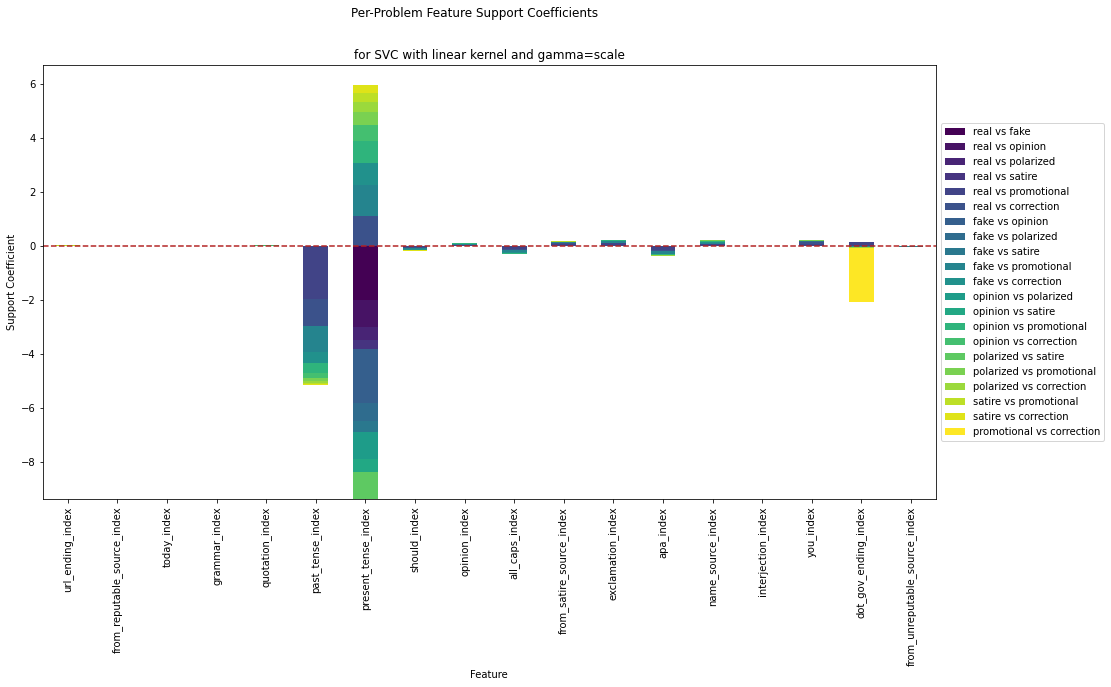

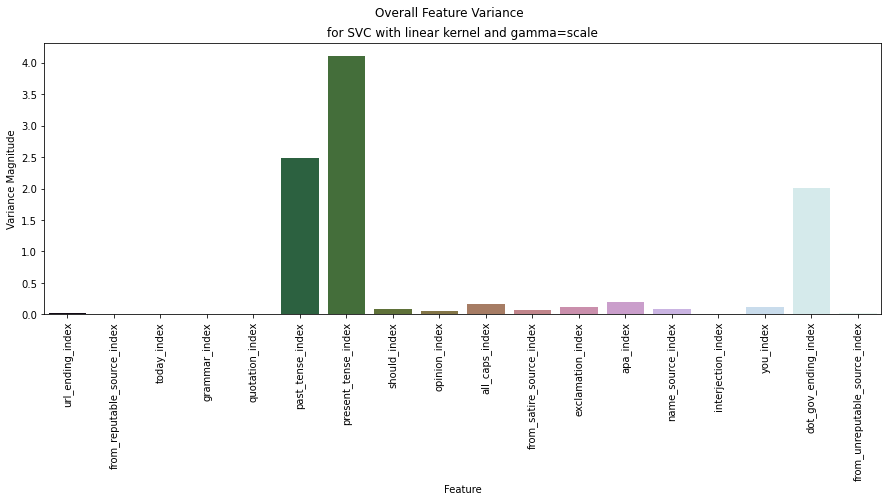

In [5]:
# load latest linear model
#model = load_latest_model(kernel='linear')

# we are only writing procedures for linear (done) and rbf (todo)
# linear has easy-to-interpret feature-weight calculations
# and rbf uses the dual coefficients, which are notoriously harder to interpret
if not model.kernel in ("linear", "rbf"):
    raise AttributeError('Initial model kernel is not linear or RBF. Only linear SVCs have primal coefficients for support weights.')

def plot_coefficients(classifier, feature_names):
    """
    Method Docstring Placeholder
    """
    #pdb.set_trace()
    global CLASS_DICT

    # extract class labels and #classes
    classes = list(CLASS_DICT.keys())
    n_classes = len(classes)

    # use itertools.combinations to create a list
    # of the pair combinations of class labels
    classes = list(combinations(classes, 2))

    # coerce the weight coefficient matrix to a pandas dataframe
    # for utility
    if classifier.kernel=='linear':
        coef = pd.DataFrame(classifier.coef_, columns=feature_names)
    else: 
        coef = pd.DataFrame(classifier.support_vectors_, columns=feature_names)
    # we must transpose `coef` to plot it in feature space
    ax = coef.T.plot(kind="bar",
                     stacked=True,
                     figsize=(16,8),
                     colormap="viridis",
                     title=f"for SVC with {classifier.kernel} kernel and gamma={classifier.gamma!s}")

    # now we need a handle for the plot's legend
    # in order to correctly label the separation problems
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # the i'th patch label in the legend
    # should contain the items of the combination pairs
    for i, label in enumerate(legend.get_texts()):
        label.set_text(f"{classes[i][0]!s} vs {classes[i][1]!s}")

    # a line at the origin to create a visual anchor
    plt.axhline(linestyle='dashed', color='firebrick')

    # setting axis labels, over-title and saving the figure
    ax.set(xlabel="Feature", ylabel="Support Coefficient")
    plt.suptitle("Per-Problem Feature Support Coefficients")
    plt.savefig(f"./figures/{len(CLASS_DICT)!s}lab_featureselection_1.png")
    return coef

coef = plot_coefficients(model, features)

# subset features with very low contributions
# in a list of features we should ablate
features_to_ablate = list(coef.mean()[coef.mean().abs()<1e-3].index)

# obtain the number of classes
# as well as weights for supports of each class
(n_classes, coefs) = *(len(model.classes_), model.coef_.transpose()),

# take the vector norm ([x dot x]^(1/2)) of each feature-weight vector (axis 1)
dot_coefs = np.apply_along_axis(lambda x: np.sqrt(x.dot(x)), 1, coefs)

### plotting
plt.figure(figsize=(15,5))

# using seaborn for utility
ax = sns.barplot(features,
                 dot_coefs,
                 palette=sns.color_palette("cubehelix", len(features)))

ax.set_title(f"for SVC with {model.kernel} kernel and gamma={model.gamma!s}")
plt.suptitle("Overall Feature Variance")
ax.set_xticklabels(features, rotation=90)
ax.set(xlabel='Feature', ylabel='Variance Magnitude')
plt.savefig(f"./figures/{len(CLASS_DICT)!s}lab_featureselection_2.png")
###

# each vector in the list below represents the support vectors for 
#coefs = model.dual_coef_

### Subset of Robust-Feature Data

#### Hand Selection Based on Visualization

In [6]:
# use only the most informative columns
# or, drop the uninformative ones
d_subset_robust = d_full.drop(features_to_ablate, axis=1)

# eliminate duplicate rows
d_subset_robust = d_subset_robust[~d_subset_robust.duplicated()]

#y = d_full[list(CLASS_DICT.keys())].to_numpy()
#x = d_full[d_full.columns.difference(list(CLASS_DICT.keys()))].to_numpy()

# x: all but the label column (features)
# y: only the label column (target)
x, y = *(d_subset_robust[d_subset_robust.columns.difference(['label'])],
         d_subset_robust['label']),

x, y = map(lambda j: j.to_numpy(), (x,y))

best_model = cross_val_best(x, y)

with open(f"models/best-model_kernel[{best_model.kernel}]gamma[{best_model.gamma}]_subset.pickle", mode="wb") as fileout:
    pickle.dump(best_model, fileout)

{11: 1}
This model got 99.84% correct || 633 out of 634.
{}
This model got 100.0% correct || 634 out of 634.
{9: 1, 1: 2}
This model got 99.53% correct || 631 out of 634.
{11: 1, 3: 1}
This model got 99.68% correct || 632 out of 634.
{3: 1}
This model got 99.84% correct || 633 out of 634.
{7: 1}
This model got 99.84% correct || 633 out of 634.
{7: 1}
This model got 99.84% correct || 633 out of 634.
{}
This model got 100.0% correct || 634 out of 634.
{}
This model got 100.0% correct || 634 out of 634.
{9: 1}
This model got 99.84% correct || 633 out of 634.
{}
This model got 100.0% correct || 634 out of 634.
{}
This model got 100.0% correct || 634 out of 634.
{3: 1}
This model got 99.84% correct || 633 out of 634.
{}
This model got 100.0% correct || 633 out of 633.
{}
This model got 100.0% correct || 633 out of 633.
{}
This model got 100.0% correct || 633 out of 633.
{5: 1}
This model got 99.84% correct || 632 out of 633.
{3: 1}
This model got 99.84% correct || 632 out of 633.
{3: 1}
Thi

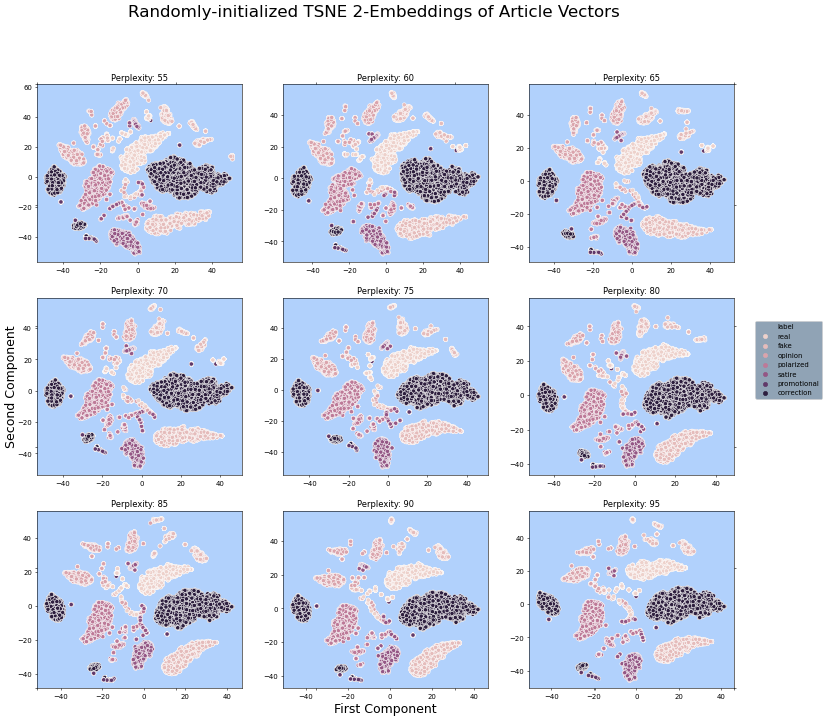

In [13]:
perps = np.arange(55, 100, 5)
try:
    embeds_list = glob.glob("./data/embeds_list*.pickle")[0]
    with open(embeds_list, mode='rb') as filein:
        embeds = pickle.load(filein)
except:
    # fit on the fly
    kl_divs, embeds = [], []
    for perplexity in perps:
        print("Fitting new TSNE...")
        ts = TSNE(init='random',
                  perplexity=perplexity,
                  random_state=random_state,
                  verbose=1, # recall: all output --> stdout, so it will render in command line
                  n_jobs=-1)
        embedded = ts.fit_transform(x)
        embeds.append(embedded)
        kl_divs.append(ts.kl_divergence_)
        print(f"Perplexity: {perplexity!s} | KLD: {np.round(ts.kl_divergence_, 3)!s}")
    scored_embeds = dict(zip(range(len(embeds)), kl_divs))
    scored_embeds = sorted(scored_embeds, key=scored_embeds.get)
    with open(f"./data/embeds_list_{'-'.join(list(map(str, perps)))}.pickle", mode='wb') as fileout:
        pickle.dump(embeds, fileout)
#fits, kl_divs = list(scored_embeds.keys()), list(scored_embeds.values())
#with open(f"./data/d-subset_TSNE-{best_ts.n_components!s}_init={best_ts.init}_perplexity={best_ts.perplexity!s}_random_state={random_state!s}.pickle", mode='wb') as fileout:
#    pickle.dump(embedded, fileout)

# convert to a dataframe if we stored the embeddings as an `ndarray`
#if not isinstance(embedded, pd.DataFrame) and isinstance(embedded, np.ndarray):
#    xe, ye = embedded[:,0], embedded[:,1]
#    embedded = pd.DataFrame({'x':xe, 'y':ye, 'label':d_subset_robust['label']})

# we need a mapping of numeric label to string label
# in a moment we will use it to assemble the plot's legend

fig, ax = plt.subplots(3, 3, figsize=(18,16), dpi=50)

for i, axrow in enumerate(ax):
    for j, subplot in enumerate(axrow):
        embedded = embeds[3*i + j] 
        xe, ye = embedded[:,0], embedded[:,1]
        subplot_ax = sns.scatterplot(xe, ye,
                                     hue=d_subset_robust['label'],
                                     ax=subplot, legend='full')
        handles, _ = subplot_ax.get_legend_handles_labels()
        subplot_ax.get_legend().remove()
        subplot_ax.set_title(f"Perplexity: {perps[3*i + j]!s}")
        subplot_ax.set_facecolor('xkcd:powder blue')

plt.figlegend(handles, ['label']+list(CLASS_DICT.keys()), loc='center right', facecolor='xkcd:blue/grey')

ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

plt.suptitle("Randomly-initialized TSNE 2-Embeddings of Article Vectors", fontsize=24);
ax.set_xlabel("First Component", fontsize=18);
ax.set_ylabel("Second Component", fontsize=18);
plt.savefig("./figures/TSNE_grid.png", dpi=200)